In [178]:
library(SummarizedExperiment)
library(VariantAnnotation)
library(Rtsne)
library(ggplot2)
library(gplots)
library(dplyr)
library(irlba)

In [179]:
vcf <- readRDS('~/Dropbox/mixed/original/Map_K10_VBC_CLI.whitelist.noindel.rds')
GT <- geno(vcf)$GT
table(c(GT))


      .     0/0     0/1     0/2     0/3     1/1 
    346 1434753    5506     199       9    5562 

In [180]:
meta <- read.csv('~/Dropbox/mixed/meta/MetaDATAJohnes2.csv', header = TRUE)
rownames(meta) <- meta$SeqID
meta <- meta[colnames(vcf), ]
head(meta)

,SeqID,SampleID,CowID,State,Farm,Type,Mix,Date,uniID,Type2,Type2_num,Contamination
MAP129,MAP129,129,1283,NY,9,tissue,1,2006,NY_1283,Ileum_20cm_from_IC_Valve,4,0
MAP381,MAP381,381,9999,VT,11,environmental,0,2004,VT_9999,environmental,100,0
MAP350,MAP350,350,228,PA,10,tissue,0,2008,PA_228,LymphNode2,6,0
MAP022,MAP022,22,1085,NY,9,fecal,0,2004,NY_1085,fecal,1,0
MAP514,MAP514,514,506,VT,11,fecal,0,2007,VT_506,fecal,1,0
MAP545,MAP545,545,120,VT,11,tissue,0,2007,VT_120,Ileum_20cm_from_IC_Valve,4,0


In [181]:
meta$Year <- meta$Date
levels(meta$Year) <- c('2004','2004','2006','2006','2008','2008','2009','2009')

In [182]:
table(meta$Year)


2004 2006 2008 2009 
 119  275  127    4 

In [183]:
GT[GT %in% c('.')] <- '0/0' # missing values
GT[GT%in% c('0/2', '0/3')] <- '0/1'
table(c(GT))
AO <- geno(vcf)$AO # alt read count
DP <- geno(vcf)$DP
is_dp_na <- is.na(DP)
DP[is_dp_na] <- 0
AO[is_dp_na] <- 0
ao_len <- sapply(AO, length)
mult <- which(ao_len > 1)
AO[mult] <- sapply(AO[mult], max)
AO <- matrix(unlist(AO), nrow = nrow(DP), ncol = ncol(DP))
X <- AO / DP # alternative allele ratio
X[is.na(X)] <- 0


    0/0     0/1     1/1 
1435099    5714    5562 

In [184]:
head(X)
dim(X)

,MAP129,MAP381,MAP350,MAP022,MAP514,MAP545,MAP401,MAP727,MAP153,MAP351,...,MAP517,MAP137,MAP944,MAP563,MAP143,MAP439,MAP380,MAP191,MAP006,MAP775
Map_K10_VBC_CLI:48_C/A,0,0.0000000,0,0,0,0,0,0.0000000,0.00000000,0,...,0,0,0,0.00000000,0,0,0,0,0.0000000,0
Map_K10_VBC_CLI:288_G/A,0,0.0000000,0,0,0,0,0,0.0000000,0.00000000,0,...,0,0,0,0.02631579,0,0,0,0,0.0000000,0
Map_K10_VBC_CLI:356_C/T,0,0.0000000,0,0,0,0,0,0.0000000,0.00000000,0,...,0,1,0,0.00000000,0,0,0,0,0.0000000,0
Map_K10_VBC_CLI:752_T/C,1,0.9897959,1,1,1,1,1,0.9939759,1.00000000,1,...,1,1,1,1.00000000,1,1,1,1,0.9834711,1
Map_K10_VBC_CLI:787_A/G,0,0.0000000,0,0,0,0,0,0.0000000,0.02409639,0,...,0,0,0,0.00000000,0,0,0,0,0.0000000,0
Map_K10_VBC_CLI:798_C/A,0,0.0000000,0,0,0,0,0,0.0000000,0.00000000,0,...,0,0,0,0.00000000,0,0,0,0,0.0000000,0


[1] 2755  525

In [185]:
X_selected <- X[,meta$State == 'VT']
head(X_selected)

,MAP381,MAP514,MAP545,MAP401,MAP560,MAP596,MAP423,MAP536,MAP409,MAP483,...,MAP508,MAP378,MAP618,MAP583,MAP487,MAP558,MAP517,MAP563,MAP439,MAP380
Map_K10_VBC_CLI:48_C/A,0.0000000,0,0,0,0,0,0,0.0000000,0.01503759,0,...,0,0,0,0.0000000,0,0,0,0.00000000,0,0
Map_K10_VBC_CLI:288_G/A,0.0000000,0,0,0,0,0,0,0.0000000,0.00000000,0,...,0,0,0,0.0000000,0,0,0,0.02631579,0,0
Map_K10_VBC_CLI:356_C/T,0.0000000,0,0,0,0,0,0,0.0000000,0.00000000,0,...,0,0,0,0.0000000,0,0,0,0.00000000,0,0
Map_K10_VBC_CLI:752_T/C,0.9897959,1,1,1,1,1,1,0.9830508,1.00000000,1,...,1,1,1,0.9923077,1,1,1,1.00000000,1,1
Map_K10_VBC_CLI:787_A/G,0.0000000,0,0,0,0,0,0,0.0000000,0.00000000,0,...,0,0,0,0.0000000,0,0,0,0.00000000,0,0
Map_K10_VBC_CLI:798_C/A,0.0000000,0,0,0,0,0,0,0.0000000,0.00000000,0,...,0,0,0,0.0000000,0,0,0,0.00000000,0,0


In [186]:
dim(X_selected)

[1] 2755  191

In [187]:
meta_selected <- meta[which(meta$State == 'VT'),]
head(meta_selected)

,SeqID,SampleID,CowID,State,Farm,Type,Mix,Date,uniID,Type2,Type2_num,Contamination,Year
MAP381,MAP381,381,9999,VT,11,environmental,0,2004,VT_9999,environmental,100,0,2004
MAP514,MAP514,514,506,VT,11,fecal,0,2007,VT_506,fecal,1,0,2006
MAP545,MAP545,545,120,VT,11,tissue,0,2007,VT_120,Ileum_20cm_from_IC_Valve,4,0,2006
MAP401,MAP401,401,9999,VT,11,environmental,0,2005,VT_9999,environmental,100,0,2004
MAP560,MAP560,560,9999,VT,11,environmental,0,2008,VT_9999,environmental,100,0,2008
MAP596,MAP596,596,9999,VT,11,environmental,0,2009,VT_9999,environmental,100,0,2008


In [188]:
GT_freq <- do.call('rbind', lapply(
    1:nrow(GT), 
    function(i) GT[i, ] %>% factor(c('0/0', '0/1', '1/1'), labels = c('AA', 'AB', 'BB')) %>% table()
)) %>% 
    as.data.frame() %>%
    mutate(snp_id = rownames(GT)) %>%
    filter(!(AB == 1 & BB == 0)) %>%
    filter(!(AB == 0 & BB == 1)) %>%
    filter(!(AA == 0 & AB == 0)) %>% 
    arrange(AB) %>% 
    print()
# GT_freq has filtered out singletons

     AA  AB  BB                      snp_id
1   523   0   2    Map_K10_VBC_CLI:6008_C/T
2   523   0   2    Map_K10_VBC_CLI:9890_C/T
3   523   0   2   Map_K10_VBC_CLI:10583_G/A
4   518   0   7   Map_K10_VBC_CLI:16181_A/G
5   522   0   3   Map_K10_VBC_CLI:23889_T/C
6   523   0   2   Map_K10_VBC_CLI:28335_G/A
7   519   0   6   Map_K10_VBC_CLI:44054_G/T
8   515   0  10   Map_K10_VBC_CLI:46975_T/C
9   523   0   2   Map_K10_VBC_CLI:49215_A/G
10  517   0   8   Map_K10_VBC_CLI:53592_C/T
11  519   0   6   Map_K10_VBC_CLI:60682_C/T
12  521   0   4   Map_K10_VBC_CLI:71014_A/G
13  523   0   2   Map_K10_VBC_CLI:71631_G/A
14   17   0 508   Map_K10_VBC_CLI:73211_T/C
15  523   0   2   Map_K10_VBC_CLI:77046_G/T
16  515   0  10   Map_K10_VBC_CLI:78045_C/T
17  521   0   4   Map_K10_VBC_CLI:91027_C/T
18  521   0   4   Map_K10_VBC_CLI:99927_A/G
19  515   0  10  Map_K10_VBC_CLI:103242_A/G
20  522   0   3  Map_K10_VBC_CLI:118442_T/A
21  523   0   2  Map_K10_VBC_CLI:120560_C/T
22  523   0   2  Map_K10_VBC_CLI

In [189]:
head(GT_freq)

AA,AB,BB,snp_id
523,0,2,Map_K10_VBC_CLI:6008_C/T
523,0,2,Map_K10_VBC_CLI:9890_C/T
523,0,2,Map_K10_VBC_CLI:10583_G/A
518,0,7,Map_K10_VBC_CLI:16181_A/G
522,0,3,Map_K10_VBC_CLI:23889_T/C
523,0,2,Map_K10_VBC_CLI:28335_G/A


In [190]:
X_no_orphan <- X_selected[GT_freq$snp_id, ]
head(X_no_orphan)
dim(X_no_orphan)

,MAP381,MAP514,MAP545,MAP401,MAP560,MAP596,MAP423,MAP536,MAP409,MAP483,...,MAP508,MAP378,MAP618,MAP583,MAP487,MAP558,MAP517,MAP563,MAP439,MAP380
Map_K10_VBC_CLI:6008_C/T,0.000000000,0.000000000,0.00000000,0,0.000000000,0.01754386,0.000000000,0,0.000000000,0.000000000,...,0,0,0,0,0,0.000000000,0,0,0,0.000000000
Map_K10_VBC_CLI:9890_C/T,0.000000000,0.000000000,0.00000000,0,0.000000000,0.00000000,0.000000000,0,0.009433962,0.000000000,...,0,0,0,0,0,0.006172840,0,0,0,0.000000000
Map_K10_VBC_CLI:10583_G/A,0.000000000,0.000000000,0.01428571,0,0.000000000,0.00000000,0.000000000,0,0.000000000,0.000000000,...,0,0,0,0,0,0.010695187,0,0,0,0.000000000
Map_K10_VBC_CLI:16181_A/G,0.000000000,0.000000000,0.00000000,0,0.004901961,0.00000000,0.006666667,0,0.000000000,0.004444444,...,0,0,0,0,0,0.003649635,0,0,0,0.000000000
Map_K10_VBC_CLI:23889_T/C,0.004273504,0.005076142,0.00000000,0,0.000000000,0.00000000,0.000000000,0,0.005050505,0.000000000,...,0,0,0,0,0,0.000000000,0,0,0,0.004739336
Map_K10_VBC_CLI:28335_G/A,0.000000000,0.000000000,0.00000000,0,0.000000000,0.00000000,0.000000000,0,0.000000000,0.000000000,...,0,0,0,0,0,0.000000000,0,0,0,0.000000000


[1] 485 191

In [191]:
X_no_orphan <- X_no_orphan[which(rowSums(X_no_orphan) != 0),] # remove snps without any samples
dim(X_no_orphan)

[1] 483 191

In [235]:
set.seed(1)
u <- irlba(X_no_orphan, nu = 1, nv = 4)$v
y_tsne <- Rtsne(scale(u), check_duplicates = FALSE)$Y

In [236]:
d <- data.frame(
    x = y_tsne[, 1], 
    y = y_tsne[, 2],
    cow_id = meta_selected$CowID,
    type_1 = meta_selected$Type %>% factor(),
    type_2 = meta_selected$Type2 %>% factor(),
    farm = meta_selected$Farm %>% factor(),
    contamination = meta_selected$Contamination %>% factor(),
    year = meta_selected$Year %>% factor(),
    date = meta_selected$Date %>% factor(),
    state = meta_selected$State %>% factor(),
    mix = meta_selected$Mix %>% factor()
)
head(d)

x,y,cow_id,type_1,type_2,farm,contamination,year,date,state,mix
-2.8417530,12.867684,9999,environmental,environmental,11,0,2004,2004,VT,0
2.8542568,-12.072865,506,fecal,fecal,11,0,2006,2007,VT,0
0.3434165,-1.446240,120,tissue,Ileum_20cm_from_IC_Valve,11,0,2006,2007,VT,0
-3.9929646,15.048260,9999,environmental,environmental,11,0,2004,2005,VT,0
-2.2099894,4.366609,9999,environmental,environmental,11,0,2008,2008,VT,0
-2.6115684,4.782293,9999,environmental,environmental,11,0,2008,2009,VT,0


In [237]:
dim(d)

[1] 191  11

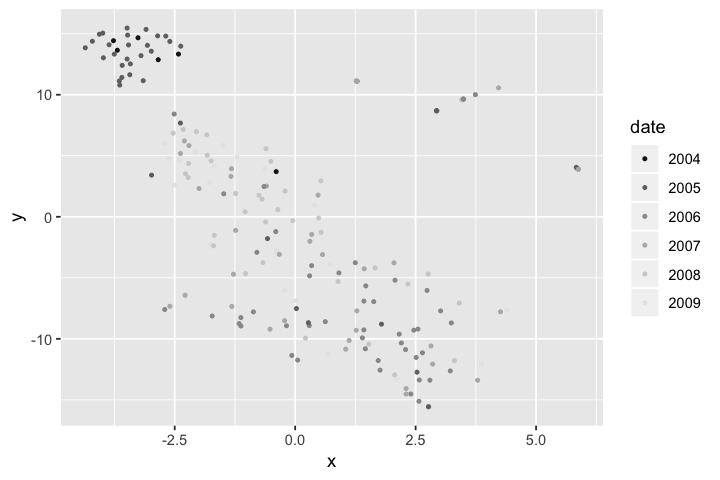

In [238]:
options(repr.plot.width=6, repr.plot.height=4)
d %>% 
    ggplot(aes(x = x, y = y, color = date)) + 
    geom_point(size = 0.75) +
    scale_color_grey(start=0.1, end=0.9)

In [239]:
w <- rowSums(X_no_orphan > 0.1 & X_no_orphan < 0.9)
#table(w)

In [240]:
d <- data.frame(
    x = y_tsne[, 1], 
    y = y_tsne[, 2],
    n_heterozygous = (X_no_orphan > 0.1 & X_no_orphan < 0.9) %>% colSums(),
    n_heterozygous_weight = ((X_no_orphan > 0.1 & X_no_orphan < 0.9) * (1 / (w + 1))) %>% colSums()
)

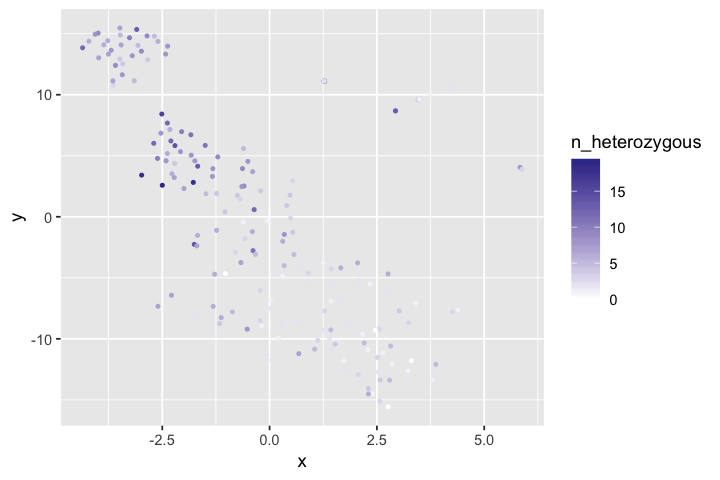

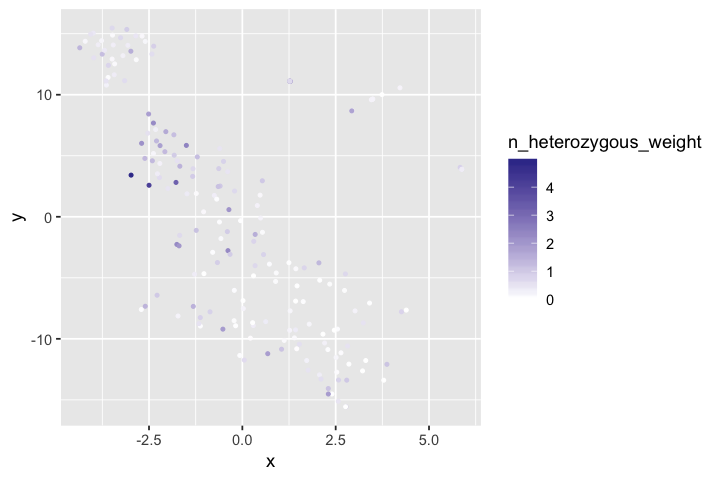

In [241]:
options(repr.plot.width=6, repr.plot.height=4)
d %>% 
    ggplot(aes(x = x, y = y, color = n_heterozygous)) + 
    geom_point(size = 0.75) +
    scale_colour_gradient2()
d %>% 
    ggplot(aes(x = x, y = y, color = n_heterozygous_weight)) + 
    geom_point(size = 0.75) +
    scale_colour_gradient2()

In [ ]:
set.seed(1)
u <- irlba(X_no_orphan, nu = 1, nv = 4)$v
y_tsne <- Rtsne(scale(u), check_duplicates = FALSE)$Y